###  Custom Convolutional Neural Network Architecture

### Imports and Setup

In [22]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns

# random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Data Preparation and Preprocessing

In [23]:
# CIFAR-100 Mean and Std values for normalization
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)

# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),     
    transforms.RandomRotation(15),         
    transforms.ColorJitter(brightness=0.2, contrast=0.2), 
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std),
])

# Normalization for validation and test
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std),
])

# Load full training dataset
full_trainset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)

# Split into training and validation
train_size = int(0.9 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

# For validation set, we use test transforms
valset.dataset.transform = transform_test

# Load Test dataset
testset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

# Data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=128, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Get class names
class_names = full_trainset.classes

print(f"Training samples: {len(trainset)}")
print(f"Validation samples: {len(valset)}")
print(f"Test samples: {len(testset)}")
print(f"Number of classes: {len(class_names)}")

Files already downloaded and verified
Files already downloaded and verified
Training samples: 45000
Validation samples: 5000
Test samples: 10000
Number of classes: 100


### Model Definition

In [24]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        
        # Second convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        
        # Third convolutional block
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.bn7 = nn.BatchNorm1d(1024)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 100)  # 100 classes in CIFAR-100
        
    def forward(self, x):
        # First block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Third block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Flatten and fully connected layers
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x

# Instantiate model
model = CustomCNN().to(device)
print(model)

# Model architecture summary 
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal trainable parameters: {count_parameters(model):,}")

# Save initial filters for visualization later
initial_filters = model.conv1.weight.data.clone().cpu()

CustomCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 

### Loss Function, Optimizer, and Learning Rate Scheduler

In [25]:
# Training settings
num_epochs = 30

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True)


# Training and Validation Loop

In [26]:
# Lists to store metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0.0
best_epoch = 0

for epoch in range(1, num_epochs + 1):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Print progress
        if (batch_idx + 1) % 50 == 0 or (batch_idx + 1) == len(trainloader):
            print(f'Epoch: {epoch}/{num_epochs} | '
                  f'Batch: {batch_idx+1}/{len(trainloader)} | '
                  f'Loss: {loss.item():.4f} | '
                  f'Acc: {100.*correct/total:.2f}%')
    
    train_loss = running_loss / len(trainset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, targets in valloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()
    
    val_loss /= len(valset)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Update learning rate based on validation loss
    scheduler.step(val_loss)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_custom_cnn_cifar100.pth')
    
    print(f"Epoch {epoch}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print('-' * 80)

print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")

# Load best model for evaluation
model.load_state_dict(torch.load('best_custom_cnn_cifar100.pth'))

Epoch: 1/30 | Batch: 50/352 | Loss: 3.9888 | Acc: 6.89%
Epoch: 1/30 | Batch: 100/352 | Loss: 3.4322 | Acc: 10.01%
Epoch: 1/30 | Batch: 150/352 | Loss: 3.5588 | Acc: 12.01%
Epoch: 1/30 | Batch: 200/352 | Loss: 3.1815 | Acc: 13.83%
Epoch: 1/30 | Batch: 250/352 | Loss: 3.0298 | Acc: 15.58%
Epoch: 1/30 | Batch: 300/352 | Loss: 2.4870 | Acc: 17.28%
Epoch: 1/30 | Batch: 350/352 | Loss: 2.7357 | Acc: 18.90%
Epoch: 1/30 | Batch: 352/352 | Loss: 2.7801 | Acc: 18.94%
Epoch 1/30 | Train Loss: 3.3940 | Train Acc: 0.1894 | Val Loss: 2.6890 | Val Acc: 0.3134
--------------------------------------------------------------------------------
Epoch: 2/30 | Batch: 50/352 | Loss: 2.5611 | Acc: 31.86%
Epoch: 2/30 | Batch: 100/352 | Loss: 2.8552 | Acc: 32.53%
Epoch: 2/30 | Batch: 150/352 | Loss: 2.3846 | Acc: 33.17%
Epoch: 2/30 | Batch: 200/352 | Loss: 2.2731 | Acc: 33.67%
Epoch: 2/30 | Batch: 250/352 | Loss: 2.2364 | Acc: 34.36%
Epoch: 2/30 | Batch: 300/352 | Loss: 2.4599 | Acc: 34.92%
Epoch: 2/30 | Batch: 

<All keys matched successfully>

# Plot Training and Validation Metrics

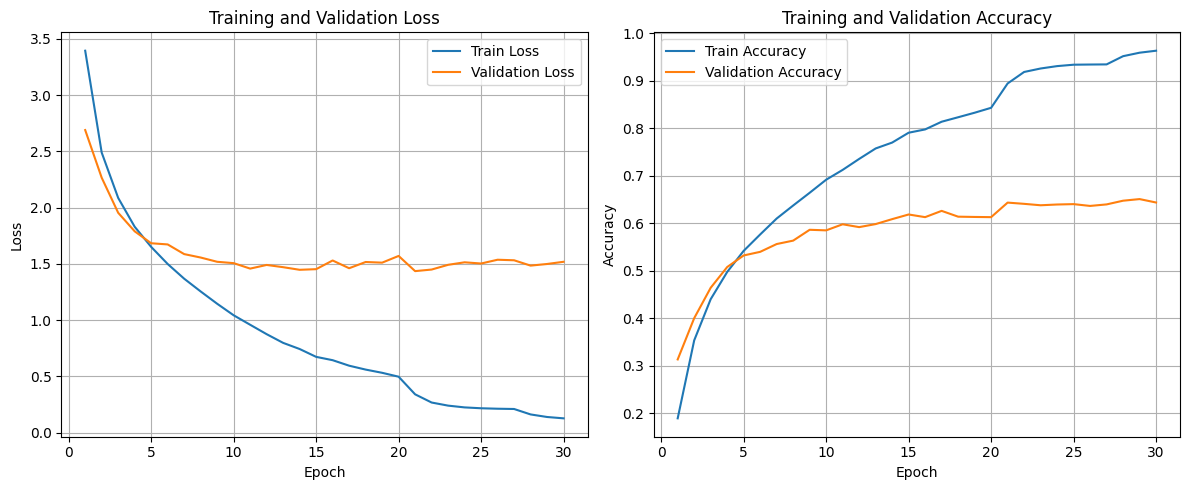

In [34]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Visualize Filters Before and After Training


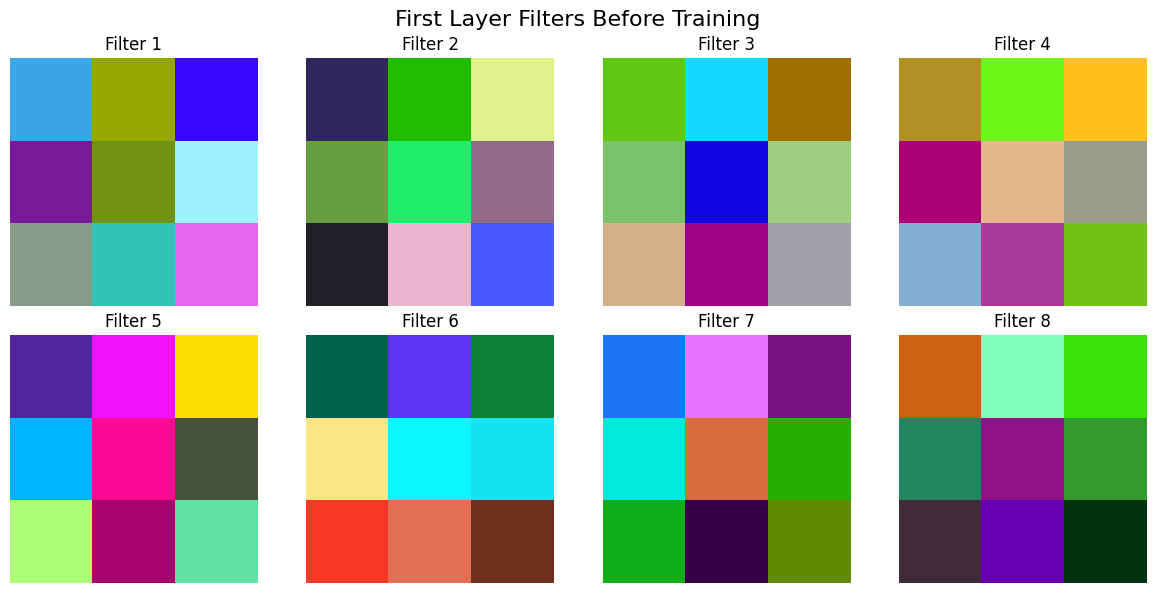

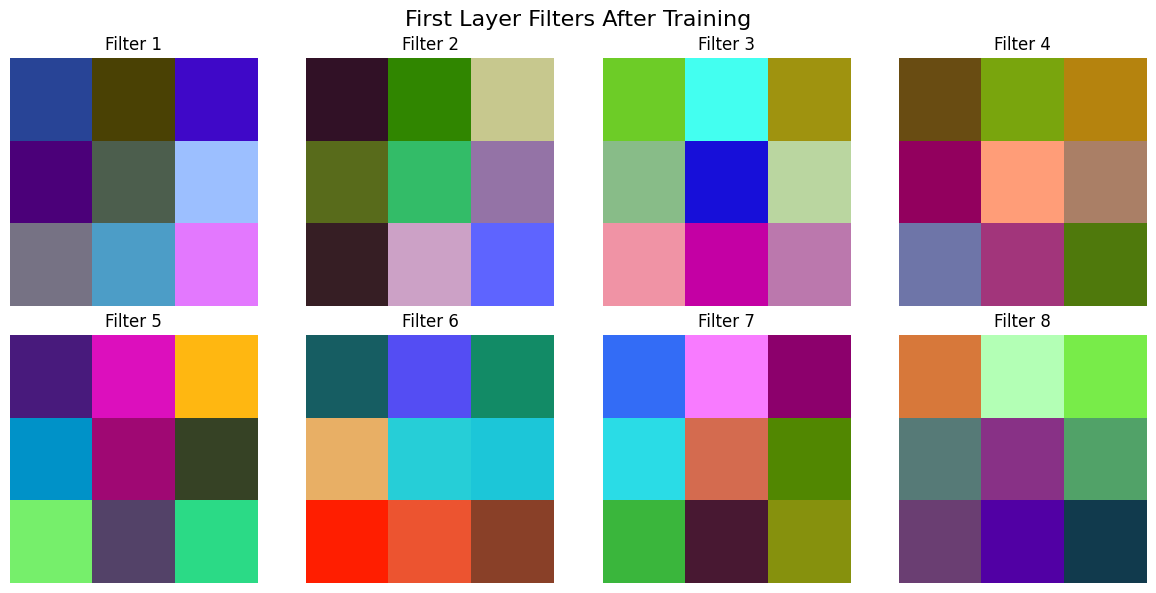

In [28]:
# Get filters after training
final_filters = model.conv1.weight.data.clone().cpu()

# Helper function to visualize filters
def plot_filters(filters, title):
    # Plot the first 8 filters 
    num_filters = min(8, filters.shape[0])
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()
    
    for i in range(num_filters):
        # Get filter and convert to numpy
        filt = filters[i].numpy()
        # Normalize filter for better visualization
        filt = (filt - filt.min()) / (filt.max() - filt.min() + 1e-8)
        # Transpose to make it channel-last format for imshow
        filt = np.transpose(filt, (1, 2, 0))
        
        if filt.shape[2] == 3:  # RGB filter
            axes[i].imshow(filt)
        else:  # Grayscale filter
            axes[i].imshow(filt[:, :, 0], cmap='gray')
            
        axes[i].set_title(f'Filter {i+1}')
        axes[i].axis('off')
    
    # Hide any unused subplots
    for i in range(num_filters, len(axes)):
        fig.delaxes(axes[i])
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Plot filters before and after training
plot_filters(initial_filters, 'First Layer Filters Before Training')
plot_filters(final_filters, 'First Layer Filters After Training')

# Evaluation on Test Set


In [29]:
# Evaluate the model on the test set
model.eval()

# Initialize lists for predictions and true labels
all_preds = []
all_labels = []

# Collect predictions
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate overall accuracy
accuracy = (all_preds == all_labels).mean()
print(f"Test Accuracy: {accuracy:.4f}")

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Generate classification report
report = classification_report(all_labels, all_preds, output_dict=True)

Test Accuracy: 0.6499


# Metrics Table and Visualization

In [30]:
# Store Metrics  
metrics_rows = []

# Fill the dataframe with metrics for each class
for i in range(100):
    # Extract TP, FP, FN, TN
    tp = cm[i, i]  # True positives
    fp = cm[:, i].sum() - tp  # False positives
    fn = cm[i, :].sum() - tp  # False negatives
    tn = cm.sum() - (tp + fp + fn)  # True negatives
    
    # Get metrics from classification report
    precision = report[str(i)]['precision']
    recall = report[str(i)]['recall']
    f1 = report[str(i)]['f1-score']
    
    # Add to list of rows
    metrics_rows.append({
        'Class': i,
        'Class Name': class_names[i],
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Create dataframe from the list of rows
metrics_df = pd.DataFrame(metrics_rows)

# Display the top 10 classes by F1-score
print("Top 10 classes by F1-score:")
print(metrics_df.sort_values('F1-Score', ascending=False).head(10))

# Display the bottom 10 classes by F1-score
print("\nBottom 10 classes by F1-score:")
print(metrics_df.sort_values('F1-Score').head(10))

# Overall metrics
overall_metrics = {
    'Accuracy': accuracy,
    'Macro Avg Precision': report['macro avg']['precision'],
    'Macro Avg Recall': report['macro avg']['recall'],
    'Macro Avg F1-Score': report['macro avg']['f1-score'],
    'Weighted Avg F1-Score': report['weighted avg']['f1-score']
}

print("\nOverall Metrics:")
for metric, value in overall_metrics.items():
    print(f"{metric}: {value:.4f}")

Top 10 classes by F1-score:
    Class  Class Name  TP  FP  FN    TN  Precision  Recall  F1-Score
82     82   sunflower  89  15  11  9885   0.855769    0.89  0.872549
94     94    wardrobe  91  18   9  9882   0.834862    0.91  0.870813
68     68        road  89  16  11  9884   0.847619    0.89  0.868293
48     48  motorcycle  92  25   8  9875   0.786325    0.92  0.847926
53     53      orange  95  30   5  9870   0.760000    0.95  0.844444
17     17      castle  85  17  15  9883   0.833333    0.85  0.841584
75     75       skunk  82  14  18  9886   0.854167    0.82  0.836735
0       0       apple  85  19  15  9881   0.817308    0.85  0.833333
56     56   palm_tree  81  15  19  9885   0.843750    0.81  0.826531
76     76  skyscraper  81  15  19  9885   0.843750    0.81  0.826531

Bottom 10 classes by F1-score:
    Class Class Name  TP  FP  FN    TN  Precision  Recall  F1-Score
72     72       seal  29  53  71  9847   0.353659    0.29  0.318681
55     55      otter  33  59  67  9841   0.35

# Predictions Visualization


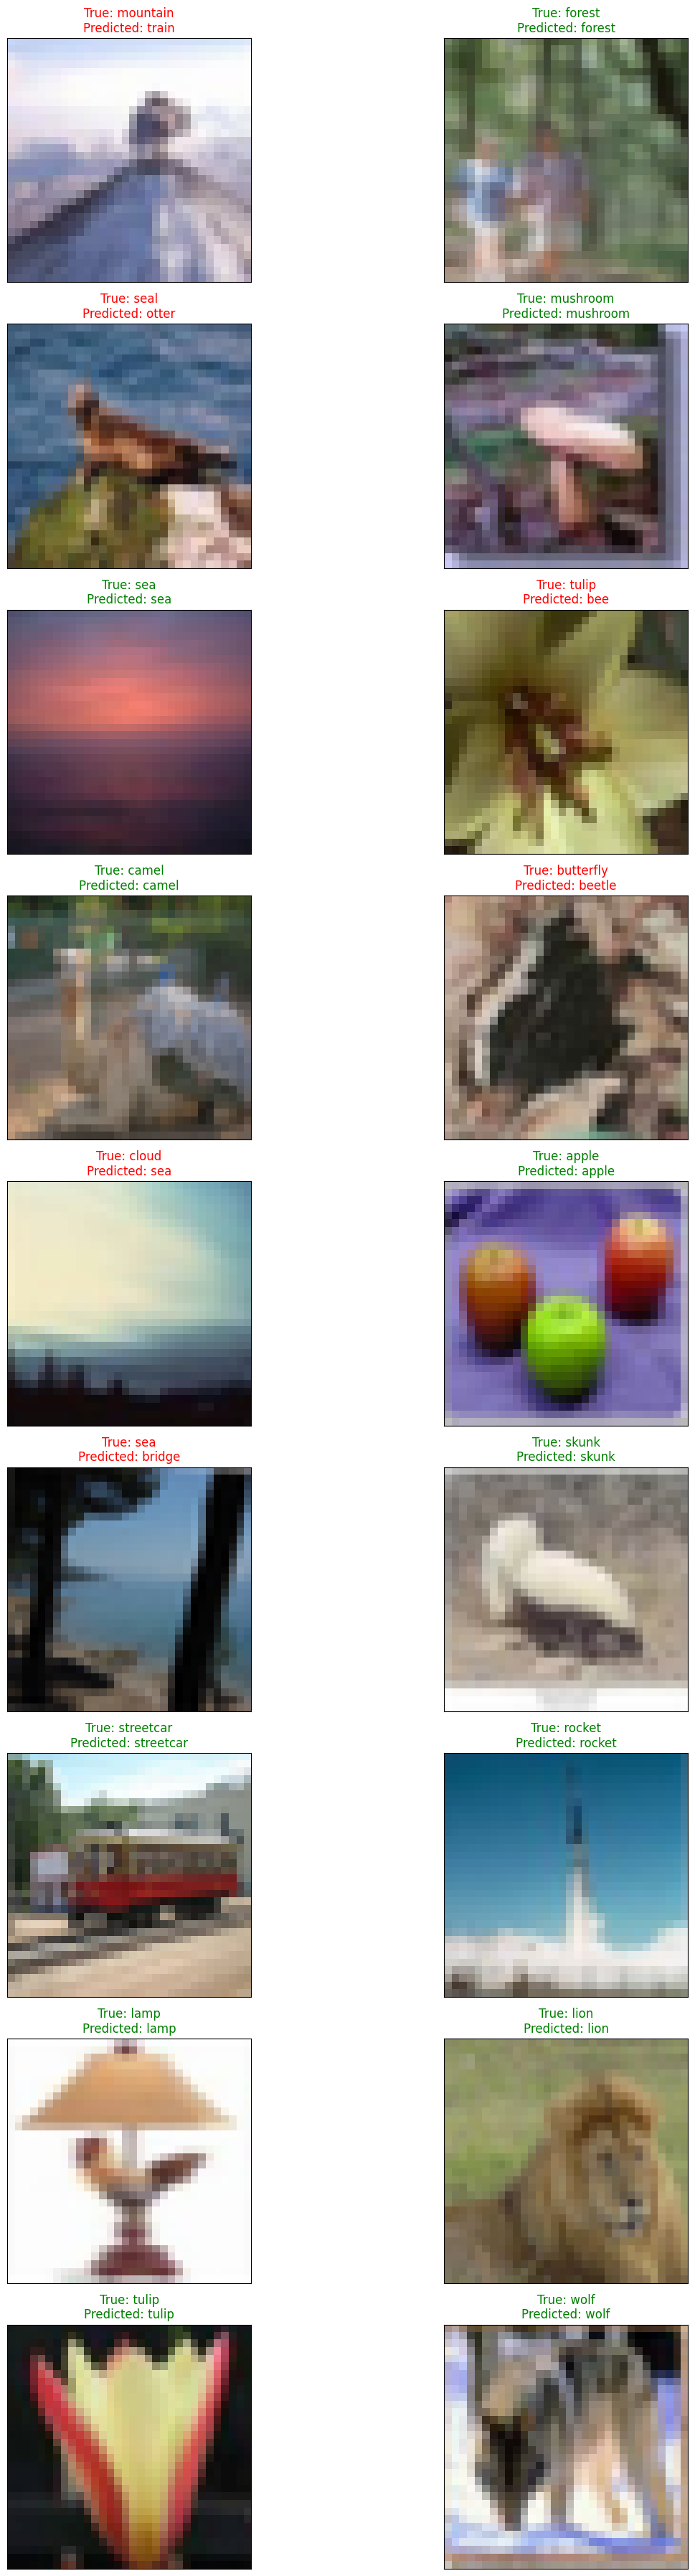

In [36]:
# Function to show sample predictions
def visualize_predictions(model, dataloader, class_names, device, num_samples=10):
    # Get a batch of test images
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
    
    # Plot the images
    fig = plt.figure(figsize=(15, num_samples*2))
    for i in range(num_samples):
        # Plot image
        ax = fig.add_subplot(num_samples//2, 2, i+1, xticks=[], yticks=[])
        
        # Get image and convert for display
        img = images[i].numpy().transpose((1, 2, 0))
        mean = np.array(cifar100_mean)
        std = np.array(cifar100_std)
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        
        # Color based on correctness of prediction
        color = 'green' if preds[i] == labels[i] else 'red'
        
        # Show true label and prediction
        ax.set_title(f"True: {class_names[labels[i]]}\nPredicted: {class_names[preds[i].item()]}", 
                     color=color)
    
    plt.tight_layout()
    plt.show()

# Visualize some sample predictions
visualize_predictions(model, testloader, class_names, device, num_samples=18)